[*********************100%***********************]  1 of 1 completed

Epoch 1/100


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0178 - val_loss: 0.0018
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0023 - val_loss: 9.2225e-04
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0011 - val_loss: 2.7621e-04
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.7126e-04 - val_loss: 7.3492e-04
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.8386e-04 - val_loss: 6.8860e-04
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 7.9988e-04 - val_loss: 2.4228e-04
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.9324e-04 - val_loss: 4.5393e-04
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.1172e-04 - val_loss: 4.4202e-04
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.1368e-04 - val_loss: 8.5523e-04
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.8872e-04 - val_loss: 5.4708e-04
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.9897e-04 - val_loss: 2.5

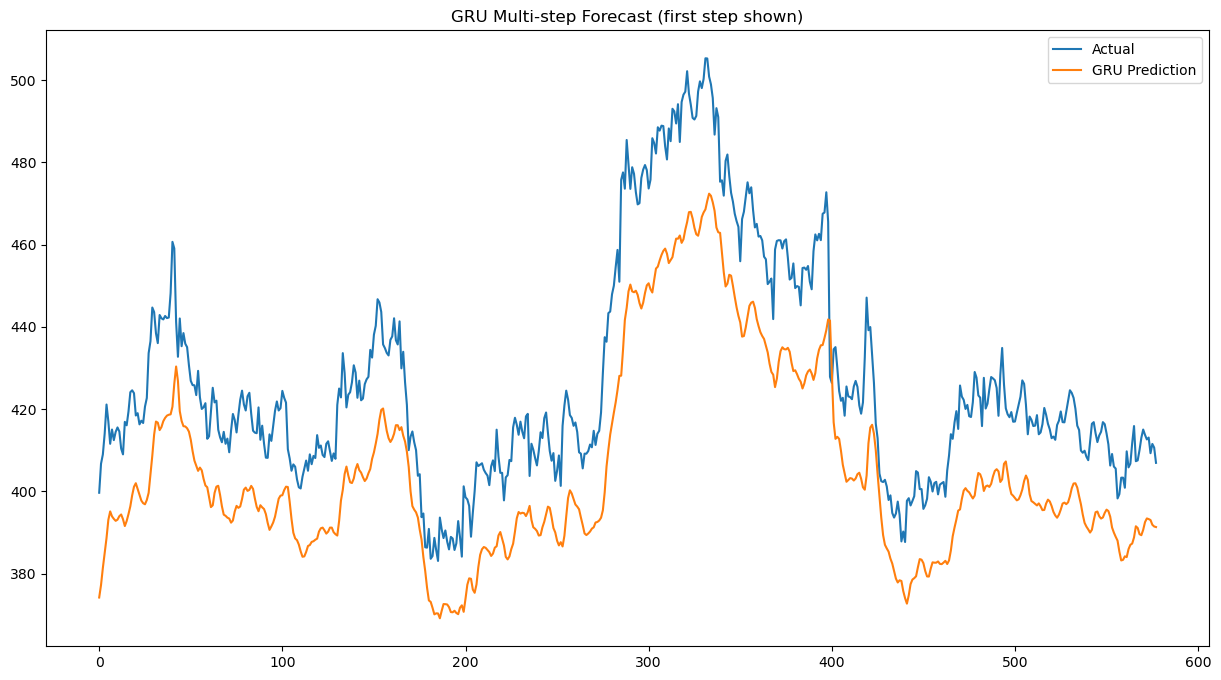

In [26]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Data download and scaling
# ------------------------------------------------------
data = yf.download("ITC.NS", start="2010-01-01")[['Close', 'Open', 'High', 'Low', 'Volume']]

sc = MinMaxScaler()
scaled_data = sc.fit_transform(data[['Close']])

time_steps = 30      # past days used for each sample
for_periods = 1     # number of days to predict ahead

X, y = [], []
for i in range(time_steps, len(scaled_data) - for_periods):
    X.append(scaled_data[i - time_steps:i, 0])
    y.append(scaled_data[i:i + for_periods, 0])  # multi-step output
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))       # (samples, timesteps, features)

# train/val/test splits (no shuffle to preserve sequence)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, shuffle=False)  # ~15% val of total

# ------------------------------------------------------
# 2. GRU model
# ------------------------------------------------------
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(50, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(50, return_sequences=True))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(50))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(for_periods))   # output 2 future values
model_gru.compile(optimizer='adam', loss='mse')

history = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=128, verbose=1
)

# ------------------------------------------------------
# 3. Predictions and evaluation
# ------------------------------------------------------
pred_gru = model_gru.predict(X_test)

# Inverse scaling
true = sc.inverse_transform(y_test)[:, 0]       # evaluate only first predicted day
predicted = pred_gru[:, 0] * (sc.data_max_[0] - sc.data_min_[0]) + sc.data_min_[0]

print("MAE:", mean_absolute_error(true, predicted))
print("MSE:", mean_squared_error(true, predicted))
print("RMSE:", np.sqrt(mean_squared_error(true, predicted)))
print("MAPE:", mean_absolute_percentage_error(true, predicted))
print("R2:", r2_score(true, predicted))
print("Explained Variance:", explained_variance_score(true, predicted))

# ------------------------------------------------------
# 4. Plot
# ------------------------------------------------------
plt.figure(figsize=(15, 8))
plt.plot(true, label='Actual')
plt.plot(predicted, label='GRU Prediction')
plt.title("GRU Multi-step Forecast (first step shown)")
plt.legend()
plt.show()
